In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import sklearn
# sklearn.__version__
# # '1.0.2'

In [3]:
# Custom rc definitions
rc = {
        'axes.spines.right': True,
        'axes.spines.top': True,
        'font.family': ['sans-serif'],
        'font.sans-serif':
        # 'Arial',
        'DejaVu Sans',
        # 'Liberation Sans',
        # 'Bitstream Vera Sans',
        # 'sans-serif',
        "xtick.bottom":True,
        'axes.edgecolor': 'indigo',
        'xtick.color': 'black',
        'figure.facecolor': "snow",
        'grid.color': 'grey',
        
}


# font definitions
font_label = {'family': 'serif',
        'color':  'darkred',
        'weight': 'semibold',
        'size': 16,
        }

font_title = {'family': 'serif',
        'color':  'black',
        'weight': 'semibold',
        'size': 16,
        }

font_fig = {'family': 'sans',
        'color':  'chocolate',
        # 'weight': 'bold', # doesn't apply to it. Must be specified independently
        # 'fontsize': 30, # doesn't apply to it. Must be specified independently
        }

In [4]:
data = pd.read_csv("../my_data/clusters.csv")

In [5]:
data.head()

,area,majoraxislength,minoraxislength,eccentricity,convexarea,equivdiameter,extent,perimeter,roundness,aspectration,class,clusters
0,6374,129.577,63.762,0.871,6476,90.087,0.662,314.656,0.809,2.032,jasmine,3
1,6946,136.304,65.738,0.876,7115,94.042,0.594,338.782,0.761,2.073,jasmine,1
2,5786,125.555,59.626,0.880,5945,85.831,0.623,307.304,0.770,2.106,jasmine,3
3,5896,127.014,59.843,0.882,6092,86.643,0.610,309.264,0.775,2.122,jasmine,3
4,6082,129.098,60.416,0.884,6204,87.999,0.661,308.106,0.805,2.137,jasmine,3


In [6]:
data = pd.get_dummies(data,columns=['class'],drop_first=True)
data.head()

,area,majoraxislength,minoraxislength,eccentricity,convexarea,equivdiameter,extent,perimeter,roundness,aspectration,clusters,class_jasmine
0,6374,129.577,63.762,0.871,6476,90.087,0.662,314.656,0.809,2.032,3,1
1,6946,136.304,65.738,0.876,7115,94.042,0.594,338.782,0.761,2.073,1,1
2,5786,125.555,59.626,0.880,5945,85.831,0.623,307.304,0.770,2.106,3,1
3,5896,127.014,59.843,0.882,6092,86.643,0.610,309.264,0.775,2.122,3,1
4,6082,129.098,60.416,0.884,6204,87.999,0.661,308.106,0.805,2.137,3,1


In [15]:
from sklearn.model_selection import \
    GridSearchCV,ShuffleSplit,train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import  Pipeline
from sklearn.preprocessing import \
    StandardScaler,MinMaxScaler,\
        RobustScaler,PolynomialFeatures

from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor,LinearRegression

from sklearn.ensemble import \
    RandomForestRegressor,GradientBoostingRegressor

In [16]:
X = data.drop(columns=["extent"])
y = data.extent

In [17]:
to_transform = ['area','majoraxislength','minoraxislength',
                'convexarea','equivdiameter','perimeter']

indexes = [ X.columns.tolist().index(value) for value in to_transform]
indexes

[0, 1, 2, 4, 5, 6]

In [18]:
# Scaler
scaler = StandardScaler()

# Column transformer
ct1 = ColumnTransformer([
    ('scale',scaler,indexes)],
    remainder='passthrough')

In [19]:
ct1

ColumnTransformer(remainder='passthrough',
                  transformers=[('scale', StandardScaler(),
                                 [0, 1, 2, 4, 5, 6])])

In [21]:
my_pipe = Pipeline([
    ("poly",PolynomialFeatures(degree=2,include_bias=False)),
    ("ct",ct1),
    # ('pca',PCA(n_components=6)),
    ('reg',LinearRegression(n_jobs=-2))
])

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=.20)

In [27]:
my_params = [
    {   # PolynomialFeatures
        "poly__degree":[3,4,5]
    },

    { # Column Transformer
        "ct__scale":[RobustScaler(),MinMaxScaler()]
    },
    
    {
        # RandomForestRegressor
        'reg':[RandomForestRegressor(random_state=42,warm_start=True,n_jobs=-2)],
        "reg__n_estimators":[50,100],
        "reg__max_depth":[3,5],
        'reg__min_samples_split':[2,3]
    },

    {
        # SGDRegressor
        "reg":[SGDRegressor(random_state=42,warm_start=True,max_iter=100)],
        'reg__early_stopping':[True,False],
        "reg__alpha":[0.0001,0.001,0.01]
    },

    {
        # GradientBoostingRegressor
        "reg":[GradientBoostingRegressor(random_state=42,warm_start=True)],
        "reg__learning_rate":[0.001,0.01,0.1,1],
        "reg__n_estimators":[50,100],
        "reg__min_samples_split":[2,3],
        "reg__max_depth":[3,5]
    }
]

my_cv = ShuffleSplit(n_splits=5,test_size=.20,random_state=42)

In [28]:
mygrid = GridSearchCV(my_pipe,param_grid=my_params,cv=my_cv)
mygrid.fit(X_train,y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 4,
                                                                          5,
                                                                          6])])),
                                       ('reg', LinearRegression(n_jobs=-2))]),
             param_grid=[{'poly__degree': [3, 4, 5]},
                         {

In [31]:
print(f"Best params: {mygrid.best_params_}\n")
print(f"Best estimator: {mygrid.best_estimator_}\n")
print(f"Best validation score: {mygrid.best_score_}")

Best params: {'reg': RandomForestRegressor(max_depth=5, n_jobs=-2, random_state=42, warm_start=True), 'reg__max_depth': 5, 'reg__min_samples_split': 2, 'reg__n_estimators': 100}

Best estimator: Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  [0, 1, 2, 4, 5, 6])])),
                ('reg',
                 RandomForestRegressor(max_depth=5, n_jobs=-2, random_state=42,
                                       warm_start=True))])

Best validation score: 0.1350220608703206


In [39]:
mygrid.best_estimator_.named_steps['reg'].n_features_

77

In [42]:
poly_components = mygrid.best_estimator_.named_steps['reg'].n_features_
poly_components_names = [f"poly_component_{component+1}" 
                        for component in range(poly_components)]
len(poly_components_names)

77

In [44]:
# With a pipeline and grid search
def feature_importance(X,model):
    importance = model.feature_importances_
    importance_sort_index = np.argsort(importance)[::-1]
    print(f"Feature importance: \n{importance}\n\n")
    print(f"Feature importance sorted index: \n{importance_sort_index}\n\n")
    print(f"Feature importance sorted: \n{importance[importance_sort_index]}\n\n")
    feature_dict = {}
    for index in importance_sort_index:
        feature_dict[X[index]] = float(importance[index])
    print(f"The features with their names:\n{feature_dict}")

    
feature_importance(poly_components_names,mygrid.best_estimator_.named_steps['reg'])

Feature importance: 
[6.19503909e-05 4.74381989e-04 1.44177460e-03 1.23513801e-04
 1.46446360e-04 7.40555622e-04 4.08415360e-04 1.73752686e-01
 1.10968101e-02 0.00000000e+00 1.26453776e-05 1.72134948e-04
 3.94397253e-04 1.27264148e-03 7.22388299e-04 5.23941642e-04
 1.79532146e-04 6.76301391e-04 9.12814679e-04 1.81203272e-03
 1.17798520e-03 4.90035874e-04 5.49654859e-04 1.28348450e-03
 2.67027539e-03 1.02446463e-03 1.23063532e-03 1.70571608e-03
 7.00044733e-03 1.52013061e-02 5.14875552e-03 1.56213415e-03
 2.11864874e-03 2.06176967e-03 1.72507029e-03 1.25890162e-03
 2.85240441e-03 2.53411994e-01 5.89743452e-04 3.59583387e-03
 3.41254063e-03 3.72100617e-04 1.01735997e-03 1.36365919e-03
 2.85451985e-03 1.26451835e-01 3.84075723e-03 6.24308474e-04
 8.10339062e-04 6.25312607e-04 1.47271765e-04 1.28235808e-03
 2.98528089e-03 1.47225905e-03 1.90646682e-03 2.00440866e-03
 1.06331614e-04 4.88296198e-04 4.37473055e-02 5.06073589e-03
 1.28086693e-03 6.30246608e-04 6.79896809e-04 1.47221041e-03
 4.

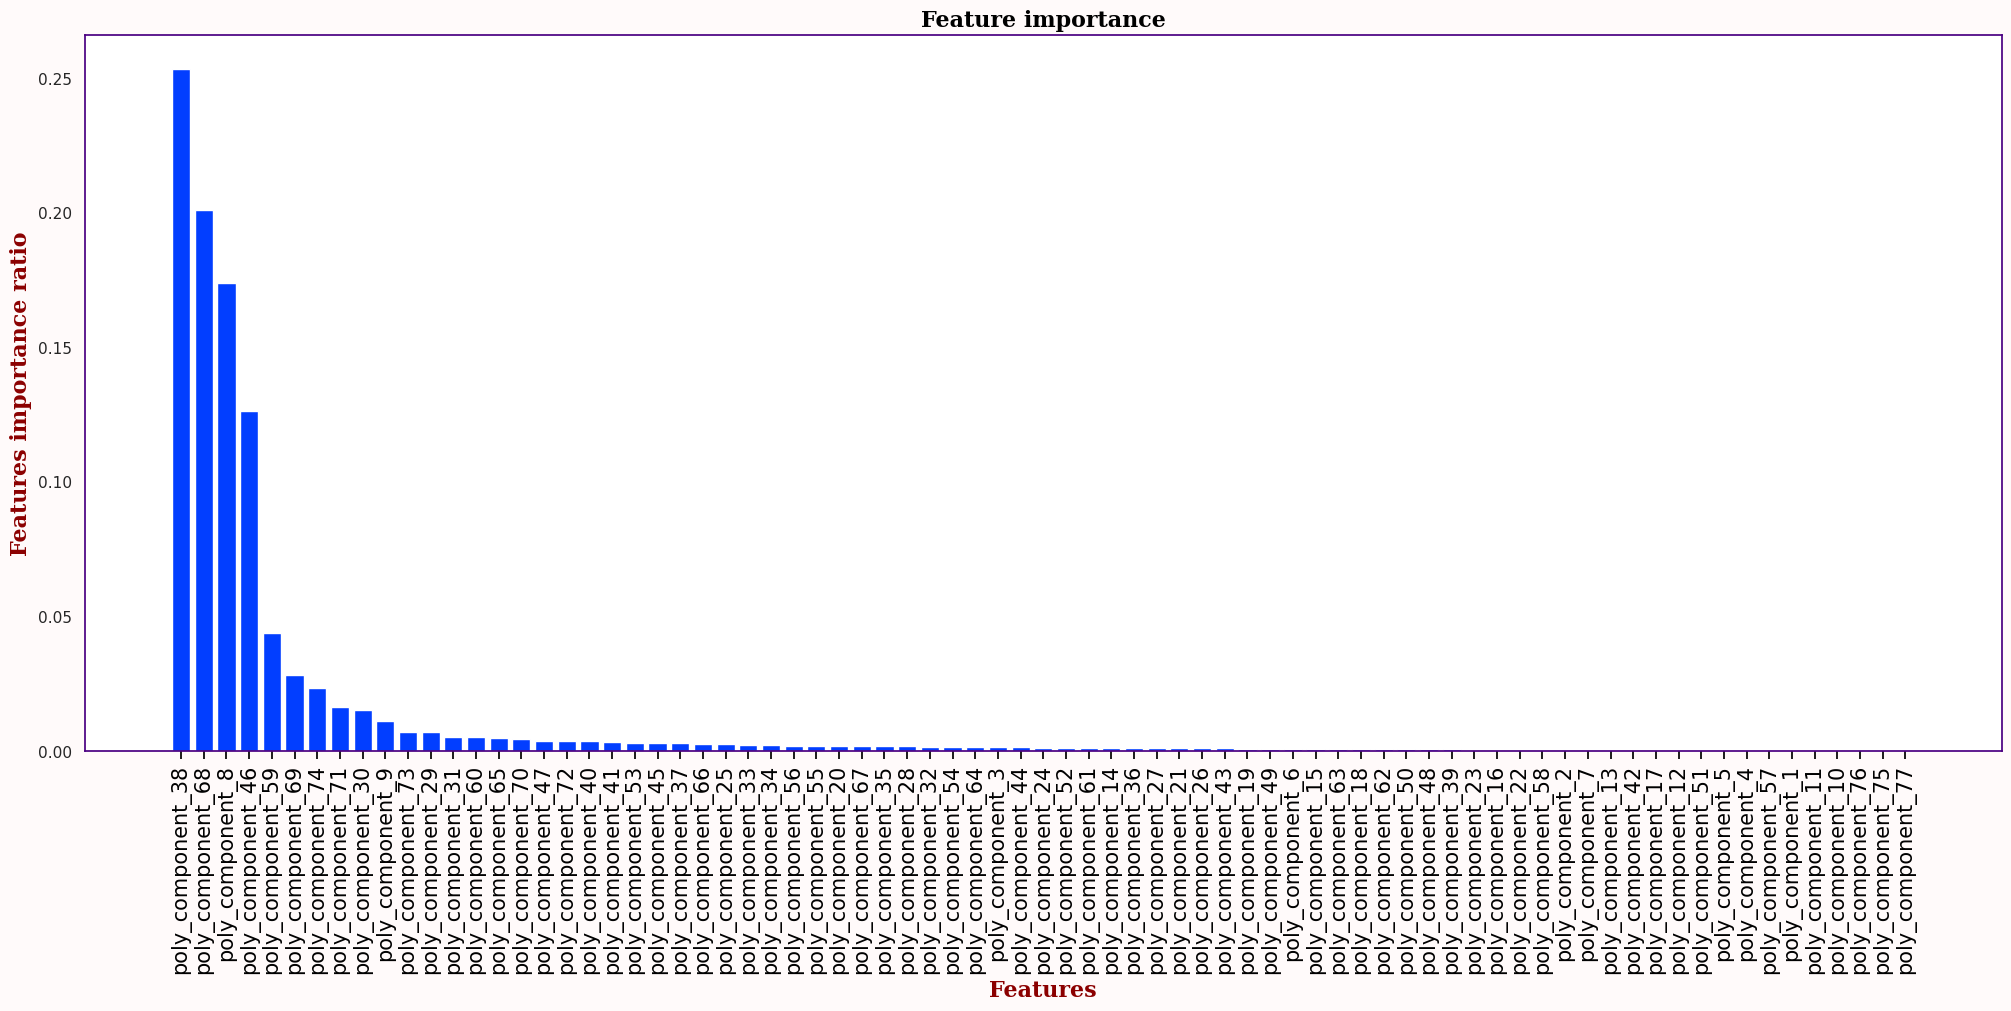

In [52]:
def plot_feature_importances(X,model):
    fig,ax = plt.subplots(1, figsize=(20,10),constrained_layout=True)
    sns.set_theme(style='white',rc=rc,palette='bright')
    
    importance = model.feature_importances_
    importance_sort_index = np.argsort(importance)[::-1]
    component_names_sorted = [X[component] 
                        for component in importance_sort_index]


    n_features = len(X)
    
    plt.bar(range(n_features),
            model.feature_importances_[importance_sort_index],
            align='center')
    plt.xticks(np.arange(n_features), component_names_sorted,
                    rotation=90,fontsize=15)
    plt.ylabel('Features importance ratio',fontdict=font_label)
    plt.xlabel('Features',fontdict=font_label)
    plt.title('Feature importance',fontdict=font_title)


plot_feature_importances(poly_components_names,mygrid.best_estimator_.named_steps['reg'])

In [53]:
from sklearn.metrics import  mean_squared_error
y_pred_test = mygrid.predict(X_test) # prediction
print(f'RMSE test: {np.around((mean_squared_error(y_test, y_pred_test,squared=False)))}') # RMSE scoe
print(f"Accuracy score (r^2): {np.around(mygrid.score(X_test, y_test),3)}") # r^2 score
print(f'Standard Deviation of Extent: {np.around(data.extent.std(),3)}') # std of Extent
# RMSE score is lower than std of Extent; Algorithm does well?

RMSE test: 0.0
Accuracy score (r^2): 0.135
Standard Deviation of Extent: 0.104


Slight improvement of $r^2$ score from 0.132 to 0.135

In [54]:
percent_error = 100* ((y_pred_test-y_test)/y_test)
data = {
    'predicted_extent':y_pred_test,
    'actual_extent':y_test,
    "percentage_error":percent_error
}
predictions_frame = pd.DataFrame(data)
predictions_frame.to_csv("../my_data/reg_predictions/reg_poly_predictions.csv"
                    ,index=True)
predictions_frame.head(5)

,predicted_extent,actual_extent,percentage_error
5277,0.582641,0.651,-10.500561
8354,0.600106,0.469,27.954328
2718,0.586918,0.547,7.297714
7895,0.553890,0.479,15.634666
4205,0.586841,0.667,-12.017809


Text(0, 0.5, 'Actual Extent')

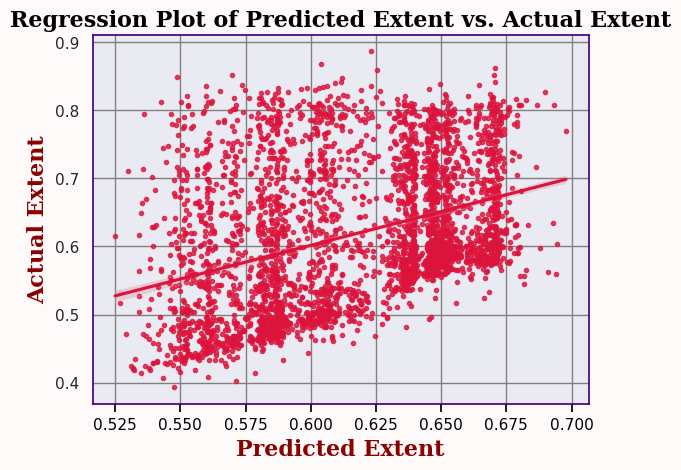

In [59]:
# Regression plot
sns.set_theme(style='darkgrid',rc=rc)
sns.regplot(data=predictions_frame,
        x='predicted_extent',
        y='actual_extent',
        fit_reg=True,
        color='crimson',
        marker='.')
plt.title('Regression Plot of Predicted Extent vs. Actual Extent',fontdict=font_title)
plt.xlabel('Predicted Extent',fontdict=font_label)
plt.ylabel('Actual Extent',fontdict=font_label)

In [56]:
import random

def generate_new_data():
    new_data_points = []
    
    for _ in range(5):
        new_data_point = []
        
        # Generate random values for the features
        new_data_point.append(random.randint(0, 10000)) # area
        new_data_point.append(random.uniform(0, 200))   # majoraxislength
        new_data_point.append(random.uniform(0, 100))   # minoraxislength
        new_data_point.append(random.uniform(0, 1))     # eccentricity    
        new_data_point.append(random.randint(0, 10000)) # convexarea
        new_data_point.append(random.uniform(0, 200))   # equivdiameter
        new_data_point.append(random.uniform(0, 500))   # perimeter
        new_data_point.append(random.uniform(0, 1))     # roundness
        new_data_point.append(random.uniform(0, 5))     # aspectration
        new_data_point.append(random.randint(0, 1))     # class
        new_data_point.append(random.randint(0, 4))     # clusters

        
        new_data_points.append(new_data_point)
    
    return new_data_points

# Generate 5 new data points
new_data = generate_new_data()
# The list
print(len(new_data),"\n")
print(new_data,"\n")

# The inner list
print(new_data[0],"\n")
print(len(new_data[0]),"\n")

5 

[[3963, 65.52128151486842, 72.45127962845345, 0.008832139182127663, 5240, 1.0957415838271034, 479.50082992121116, 0.70418367589573, 4.004114466123712, 1, 3], [979, 70.2086274743763, 93.37822729307806, 0.7367753213769169, 5606, 162.09403509316337, 429.7820113475716, 0.6472153908904046, 4.434437950640355, 1, 4], [1797, 142.91604075787464, 53.1163161733175, 0.49339326919865323, 7712, 72.88936751171977, 496.1576330737641, 0.17692604172524762, 0.24973758390408107, 0, 1], [8343, 46.311477645025725, 77.34886240045026, 0.1587554198593556, 9861, 41.43066044140647, 125.04936483935658, 0.9172273767321265, 3.756085278180425, 0, 3], [697, 47.13101421251162, 6.158588189782932, 0.6037358852971321, 6592, 93.68576843538416, 434.84643454256917, 0.287088205769891, 4.290057237705491, 0, 1]] 

[3963, 65.52128151486842, 72.45127962845345, 0.008832139182127663, 5240, 1.0957415838271034, 479.50082992121116, 0.70418367589573, 4.004114466123712, 1, 3] 

11 



In [57]:
mygrid.predict(new_data)

array([0.67364027, 0.65721451, 0.56014124, 0.6611005 , 0.55599991])

In [58]:
import pickle

with open('../model/regression_poly.pkl','wb') as f:
    pickle.dump(mygrid.best_estimator_,f)